# Titanic - Machine Learning from Disaster
## Predict survival on the Titanic and get familiar with ML basics

In [1]:
#import necessary libraries

#general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#data preprocessing
from sklearn.preprocessing import StandardScaler

#machine learning algorithms
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

#model evaluation
from sklearn.model_selection import cross_val_score, cross_validate




### Data Exploration

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

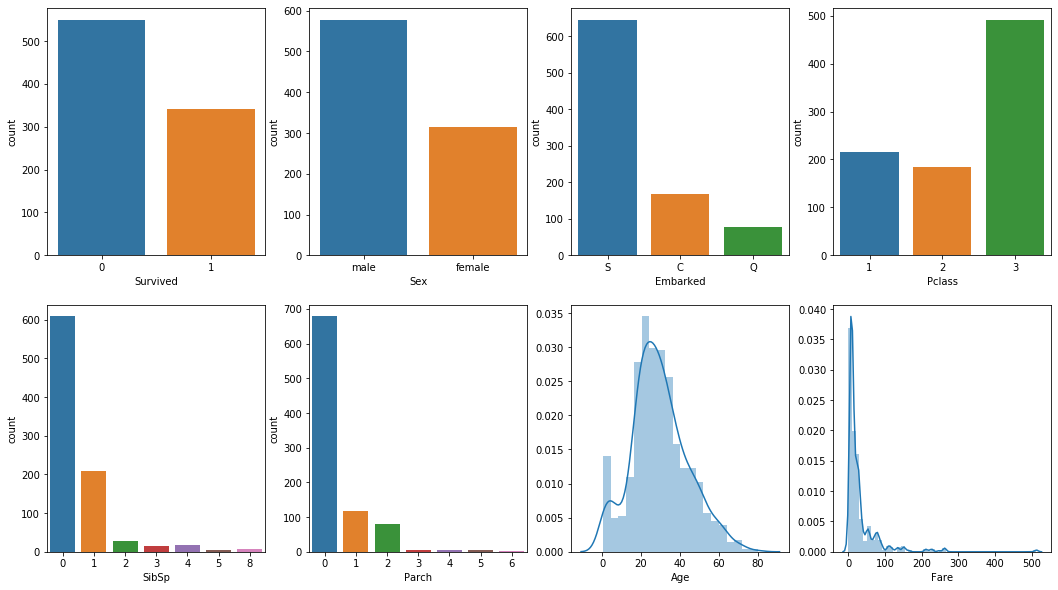

In [2]:
%matplotlib inline

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

display(train_df.head())
display(train_df.describe())
display(train_df.info())

#Charts for each attribute
fig, axes = plt.subplots(2,4, figsize=(18, 10))
sns.countplot(x='Survived', data=train_df, ax=axes[0, 0])
sns.countplot(x='Sex', data=train_df, ax=axes[0, 1])
sns.countplot(x='Embarked', data=train_df, ax=axes[0, 2])
sns.countplot(x='Pclass', data=train_df, ax=axes[0, 3])
sns.countplot(x='SibSp', data=train_df, ax=axes[1, 0])
sns.countplot(x='Parch', data=train_df, ax=axes[1, 1])
sns.distplot(train_df['Age'], ax=axes[1, 2])
sns.distplot(train_df['Fare'], ax=axes[1, 3])

### Data Cleaning

In [123]:
def fam_survival(df):
    survival = []
    for i, row in df.iterrows():
        if (row['Size']>1) & (row['Survived_max']==1):
            survival.append(1)
        elif (row['Size']>1) & (row['Survived_min']==0):
            survival.append(0)
        else:
            survival.append(0.5)
    return survival

def group_survival(df):
    survival_group = []
    for i, row in df.iterrows():
        if row['Ticket'] == 'Unknown':
            survival_group.append(0.5)
        elif (row['Survived_max'] == 1) & (row['Size']>1) :
            survival_group.append(1)
        elif (row['Survived_min'] == 0) & (row['Size']>1):
            survival_group.append(0)
        else:
            survival_group.append(0.5)
    return survival_group

def family_size(df):
    family_size = []
    for i, row in df.iterrows():
        if row['Family_size'] == 1:
            family_size.append(0) #alone
        elif row['Family_size'] <= 4:
            family_size.append(1) #small family
        else:
            family_size.append(2) #big family
    return family_size

In [182]:
#Both are needed later
y_train = train_df['Survived']
passID = test_df['PassengerId']

#make sure we don't mix the records
train_df['df'] = 'train'
test_df['df'] = 'test'

#combine both datasets
full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

#extract title of column name
full_df['Title'] = [x for x in full_df['Name'].map(lambda x: x.split(', ')[1].split('.')[0])]
dict_titles = {'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master', 'Don': 'Mr', 'Rev': 'Mr', 
               'Dr': 'Mr', 'Mme': 'Mrs', 'Ms': 'Miss', 'Major': 'Mr', 'Lady': 'Mrs', 'Sir': 'Mr',
               'Mlle': 'Miss', 'Col': 'Mr', 'Capt': 'Mr', 'the Countess': 'Mrs', 'Jonkheer': 'Mr', 'Dona': 'Mrs'}
full_df['Title'] = full_df['Title'].replace(dict_titles)
full_df['Title'] = full_df['Title'].replace({'Mr': 0, 'Mrs': 1, 'Miss': 2, 'Master': 3})

#get family information and see one in the family survived -> if yes then 1, if no then 0, if no family then 0.5
full_df['Last_name'] = full_df['Name'].apply(lambda x: str.split(x, ',')[0])
full_df['Fare_family'] = full_df['Fare'].fillna(full_df['Fare'].mean())

families_survived_min = full_df[['Last_name', 'Fare_family', 'Survived']].groupby(['Last_name', 'Fare_family']).min().reset_index()
families_survived_max = full_df[['Last_name', 'Fare_family', 'Survived']].groupby(['Last_name', 'Fare_family']).max().reset_index()
families_size = full_df[['Last_name', 'Fare_family']].groupby(['Last_name', 'Fare_family']).size().to_frame().reset_index()
families = families_survived_min.merge(families_survived_max, on=['Last_name', 'Fare_family'], suffixes=['_min', '_max'])
families = families.merge(families_size, on=['Last_name', 'Fare_family'])
families.columns = ['Last_name', 'Fare_family', 'Survived_min', 'Survived_max', 'Size']
families['Family_survival'] = fam_survival(families)
families_to_merge = families[['Last_name', 'Fare_family', 'Family_survival']]
full_df = full_df.merge(families_to_merge, on=['Last_name', 'Fare_family'])

#get family survival for groups if no family survival information
full_df['Ticket'] = full_df['Ticket'].fillna('Unknown')
groups_survived = full_df[['Ticket', 'Survived']].groupby(['Ticket']).agg(['min', 'max']).reset_index()
groups_survived_size = full_df[['Ticket', 'Survived']].groupby(['Ticket']).size().to_frame().reset_index()
groups_survived = groups_survived.merge(groups_survived_size, on='Ticket')
groups_survived = groups_survived.drop(columns=['Ticket'], axis=1)
groups_survived.columns = ['Ticket', 'Survived_min', 'Survived_max', 'Size']
groups_survived['Group_survival'] = group_survival(groups_survived)

full_df = full_df.merge(groups_survived[['Ticket', 'Group_survival']],on='Ticket')
full_df.loc[full_df['Family_survival']==0.5, 'Family_survival'] = full_df['Group_survival'] 

#encode Sex column
full_df = pd.get_dummies(data=full_df, columns=['Sex'], drop_first=True)
full_df.rename({'Sex_male': 'Sex'}, inplace=True, axis=1)

#column Age: fill null values with median and put into 4 equally big buckets
full_df['Age'] = full_df['Age'].fillna(full_df['Age'].median())
full_df['Age'] = pd.qcut(full_df['Age'], q=4, labels=[0,1,2,3])
full_df['Age'] = pd.to_numeric(full_df['Age'])

#column SibSp / Parch: combine both because seems to be family related
full_df['Family_size'] = full_df['SibSp'] + full_df['Parch'] + 1
full_df['Family_size'] = family_size(full_df)

#column Fare: fill null values with median and put into 4 equally big buckets
full_df['Fare'] = full_df['Fare'].fillna(full_df['Fare'].median())
full_df['Fare'] = pd.qcut(full_df['Fare'], q=6, labels=[0,1,2,3,4,5])
full_df['Fare'] = pd.to_numeric(full_df['Fare'])
full_df = full_df.sort_values(by='PassengerId')

#column Embarked: fill null values with mode and hot encode it
full_df['Embarked'] = full_df['Embarked'].fillna(full_df['Embarked'].mode())
full_df.iloc[61,10] = 'S'
full_df.iloc[829,10] = 'S'
full_df['Embarked'] = full_df['Embarked'].replace({'S':0, 'C':1, 'Q':2})

#column cabin: fill null values with unknown and hot encode it
full_df['Cabin'].loc[~full_df['Cabin'].isnull()] = 1 #known
full_df['Cabin'] = full_df['Cabin'].fillna(0) #unknown

#drop unnecessary columns
columns_drop = ['PassengerId','Name', 'SibSp', 'Parch', 'Ticket', 'Last_name', 'Fare_family', 'Group_survival', 'Survived']
full_df = full_df.drop(columns=columns_drop, axis=1)


#split train and test dataset again
X = full_df[full_df['df']=='train']
X = X.drop(columns=['df'], axis=1)
X_test = full_df[full_df['df']=='test']
X_test = X_test.drop(columns=['df'], axis=1)

display(X.head())
print(X.info())


/Users/jan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/Users/jan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Pclass,Age,Fare,Cabin,Embarked,Title,Family_survival,Sex,Family_size
0,3,0,0,0,0,0,0.5,1,1
1,1,3,5,1,1,1,1.0,0,1
3,3,1,1,0,0,2,0.5,0,0
4,1,2,4,1,0,1,1.0,0,1
6,3,2,1,0,0,0,0.5,1,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 1061
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pclass           891 non-null    int64  
 1   Age              891 non-null    int64  
 2   Fare             891 non-null    int64  
 3   Cabin            891 non-null    int64  
 4   Embarked         891 non-null    int64  
 5   Title            891 non-null    int64  
 6   Family_survival  891 non-null    float64
 7   Sex              891 non-null    uint8  
 8   Family_size      891 non-null    int64  
dtypes: float64(1), int64(7), uint8(1)
memory usage: 63.5 KB
None


### Building simple models

In [183]:
#Standard scaling the datasets
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
X_test_real = scaler.transform(X_test)

#dataframe to compare scores
model_names = {'model name': ['LogisticRegression', 'SVC', 'RandomForestClassifier', 'XGBClassifier']}
score_df = pd.DataFrame(model_names)


#Initiate models
logreg = LogisticRegression()
svc = SVC(probability=True)
rfc = RandomForestClassifier(random_state=1)
xgbc = xgb.XGBClassifier(random_state=1)

models = [logreg, svc, rfc, xgbc]
scores_v1 = []

for model in models:
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10)
    scores_v1.append(score.mean())
    
score_df['scores simple'] = scores_v1
display(score_df)

,model name,scores simple
0,LogisticRegression,0.876542
1,SVC,0.869788
2,RandomForestClassifier,0.869763
3,XGBClassifier,0.866429


### Feature Selection

In [184]:
#get feature importance
feature_imp = pd.DataFrame({'feature': X.columns.to_list(), 'importance': xgbc.feature_importances_ })
print(feature_imp)

feature_imp_rfc = pd.DataFrame({'feature': X.columns.to_list(), 'importance': rfc.feature_importances_ })
print(feature_imp)

feature_imp_logreg = pd.DataFrame({'feature': X.columns.to_list(), 'importance': logreg.coef_[0]})
print(feature_imp_logreg)


#remove embarked features
X = X.drop(columns=['Embarked', 'Sex'], axis=1)
X_test = X_test.drop(columns=['Embarked', 'Sex'], axis=1)

#Scaling new data set
X_train = scaler.fit_transform(X)
X_test_real = scaler.transform(X_test)

#Models with feature selection
scores_v2 = []

for model in models:
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10)
    scores_v2.append(score.mean())
    
score_df['scores selection'] = scores_v2
display(score_df)

           feature  importance
0           Pclass    0.090226
1              Age    0.133459
2             Fare    0.176692
3            Cabin    0.080827
4         Embarked    0.073308
5            Title    0.107143
6  Family_survival    0.206767
7              Sex    0.060150
8      Family_size    0.071429
           feature  importance
0           Pclass    0.090226
1              Age    0.133459
2             Fare    0.176692
3            Cabin    0.080827
4         Embarked    0.073308
5            Title    0.107143
6  Family_survival    0.206767
7              Sex    0.060150
8      Family_size    0.071429
           feature  importance
0           Pclass   -0.273019
1              Age   -0.167864
2             Fare    0.049070
3            Cabin    0.426868
4         Embarked   -0.024683
5            Title    0.670549
6  Family_survival    1.846424
7              Sex   -1.010197
8      Family_size   -0.744601


,model name,scores simple,scores selection
0,LogisticRegression,0.876542,0.863109
1,SVC,0.869788,0.872010
2,RandomForestClassifier,0.869763,0.865256
3,XGBClassifier,0.866429,0.875393


### Hyperparameter Tuning

In [185]:
#Grid Search Logistic Regression
params_logreg = {'C': np.logspace(0, 4, 10), 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

grid_logreg = GridSearchCV(estimator = LogisticRegression(), param_grid = params_logreg, verbose = True,
                          scoring = 'accuracy', cv=10)

grid_logreg.fit(X_train, y_train)
print(grid_logreg.best_params_)
print(grid_logreg.best_score_)

#best parameters: C: 2.7825594022071245 and solver: newton-cg

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'C': 2.7825594022071245, 'solver': 'newton-cg'}
0.8642197253433208


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.4s finished


In [151]:
#Grid Search SVC
params_svc = {'C': [0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 50, 100], 'gamma': [0.001, 0.01, 0.1, 1]}

grid_svc = GridSearchCV(estimator = SVC(probability=True), param_grid = params_svc, verbose = True,
                          scoring = 'accuracy', cv=10)
grid_svc.fit(X_train, y_train)
print(grid_svc.best_params_)
print(grid_svc.best_score_)
#best parameter: C:0.1 gamma: 0.01

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'C': 0.1, 'gamma': 0.01}
0.876541822721598


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   23.6s finished


In [153]:
#Grid Search RandomForestClassifier
params_rfc = {'n_estimators': [10, 25, 50, 75, 100], 'max_depth': [3, None], 'max_features': [1, 3, 5, 6, 8],
             'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [2, 4, 6, 8, 10]}

grid_rfc = GridSearchCV(estimator = RandomForestClassifier(random_state=1), param_grid = params_rfc, verbose = True,
                          scoring = 'accuracy', cv=10, n_jobs=4)
grid_rfc.fit(X_train, y_train)
print(grid_rfc.best_params_)
print(grid_rfc.best_score_)

#best parameters: {'max_depth': None, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 75}

Fitting 10 folds for each of 1250 candidates, totalling 12500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   37.4s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 4876 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 6376 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 8076 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done 9976 tasks      | elapsed:  8.3min
[Parallel(n_jobs=4)]: Done 12076 tasks      | elapsed: 10.4min


{'max_depth': None, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 75}
0.8753932584269662


[Parallel(n_jobs=4)]: Done 12500 out of 12500 | elapsed: 10.9min finished


In [154]:
#XGBClassifier step 1
params_xgbc = {'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2], 
               'n_estimators': [10, 25, 50, 75, 100, 250, 500, 750, 1000]}
grid_xgbc = GridSearchCV(estimator = xgb.XGBClassifier(random_state=1), param_grid = params_xgbc, verbose = True,
                          scoring = 'accuracy', cv=10, n_jobs=4)
grid_xgbc.fit(X_train, y_train)
print(grid_xgbc.best_estimator_)
print(grid_xgbc.best_score_)
#best params: learning_rate: 0.1, n_estimators: 100

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 101 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 313 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 642 tasks      | elapsed:   54.4s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
0.8798626716604245


[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.1min finished


In [155]:
#XGBClassifier step 2
params_xgbc = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
               'min_child_weight': [1, 2, 3, 4, 5, 6]}
grid_xgbc = GridSearchCV(estimator = xgb.XGBClassifier(random_state=1, learning_rate=0.1, n_estimators=100),
                         param_grid = params_xgbc, verbose = True, 
                         scoring = 'accuracy', cv=10, n_jobs=4)
grid_xgbc.fit(X_train, y_train)
print(grid_xgbc.best_estimator_)
print(grid_xgbc.best_score_)
#best params: max_depth: 3, min_child_weight: 1

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   14.8s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
0.8798626716604245


[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed:   19.8s finished


In [156]:
#XGBClassifier step 3
params_xgbc = {'gamma': [i*0.1 for i in range(0,5)]}
grid_xgbc = GridSearchCV(estimator = xgb.XGBClassifier(random_state=1, learning_rate=0.1, n_estimators=100, 
                                                       max_depth=3, min_child_weight=1),
                         param_grid = params_xgbc, verbose = True, 
                         scoring = 'accuracy', cv=10, n_jobs=4)
grid_xgbc.fit(X_train, y_train)
print(grid_xgbc.best_estimator_)
print(grid_xgbc.best_score_)
#best param: gamma: 0.0

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0.0, learning_rate=0.1,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)
0.8798626716604245


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished


In [157]:
#XGBClassifier step 4
params_xgbc = {'subsample': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1], 
               'colsample_bytree': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1] }
grid_xgbc = GridSearchCV(estimator = xgb.XGBClassifier(random_state=1, learning_rate=0.1, n_estimators=100, 
                                                       max_depth=3, min_child_weight=1, gamma=0.0),
                         param_grid = params_xgbc, verbose = True, 
                         scoring = 'accuracy', cv=10, n_jobs=4)
grid_xgbc.fit(X_train, y_train)
print(grid_xgbc.best_estimator_)
print(grid_xgbc.best_score_)
#best param: subsample: 0.95, colsample_bytree: 0.6

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    9.2s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.6, gamma=0.0, learning_rate=0.1,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.95)
0.8798751560549313


[Parallel(n_jobs=4)]: Done 810 out of 810 | elapsed:   22.8s finished


In [158]:
#XGBClassifier step 5
params_xgbc = {'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]}
grid_xgbc = GridSearchCV(estimator = xgb.XGBClassifier(random_state=1, learning_rate=0.1, n_estimators=100, 
                                                       max_depth=3, min_child_weight=1, gamma=0.0, subsample=0.95,
                                                      colsample_bytree=0.6),
                         param_grid = params_xgbc, verbose = True, 
                         scoring = 'accuracy', cv=10, n_jobs=4)
grid_xgbc.fit(X_train, y_train)
print(grid_xgbc.best_estimator_)
print(grid_xgbc.best_score_)

#best param: reg_alpha: 1e-05

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.6, gamma=0.0, learning_rate=0.1,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=1, reg_alpha=1e-05,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.95)
0.8798751560549313


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.2s finished


### Re-run the models with tuned hyperparameters

In [160]:
#Initiate models
logreg_tuned = LogisticRegression(C=2.7825594022071245, solver='newton-cg')
svc_tuned = SVC(probability=True, C=0.1, gamma=0.01)
rfc_tuned = RandomForestClassifier(random_state=1, max_depth= None, max_features=1, 
                                   min_samples_leaf=2, min_samples_split=2, n_estimators=75)
xgbc_tuned = xgb.XGBClassifier(random_state=1, learning_rate=0.1, n_estimators=100, 
                               max_depth=3, min_child_weight=1, gamma=0.0, subsample=0.95,
                               colsample_bytree=0.6, reg_alpha=1e-05)
models = [logreg_tuned, svc_tuned, rfc_tuned, xgbc_tuned]
scores_v3 = []

for model in models:
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10)
    scores_v3.append(score.mean())
    
score_df['scores tuned'] = scores_v3
display(score_df)

,model name,scores simple,scores selection,scores tuned
0,LogisticRegression,0.876542,0.876542,0.876542
1,SVC,0.869788,0.872047,0.876542
2,RandomForestClassifier,0.869763,0.867516,0.875393
3,XGBClassifier,0.866429,0.879863,0.879875


### Combining Models via Voting Classifier

In [161]:
#Hard Voting Classifier
model_hard = VotingClassifier(estimators=[('SVC', svc_tuned), ('RandomForestClassifier', rfc_tuned),
                                          ('XGBClassifier',xgbc_tuned)],
                             voting='hard')
score_hard = cross_val_score(model_hard, X_train, y_train, scoring='accuracy', cv=10)
model_hard.fit(X_train, y_train)
print(score_hard.mean())

0.8798751560549313


In [162]:
#Soft Voting Classifier
model_soft = VotingClassifier(estimators=[('RandomForestClassifier', rfc_tuned), ('XGBClassifier',xgbc_tuned)],
                             voting='soft')
score_soft = cross_val_score(model_soft, X_train, y_train, scoring='accuracy', cv=10)
model_soft.fit(X_train, y_train)
print(score_soft.mean())

0.8731460674157303


### Making final submission

In [163]:
# prediction on new dataset
y_pred = model_hard.predict(X_test_real)

submission_df = pd.DataFrame({'PassengerId': passID, 'Survived': y_pred})
display(submission_df)

submission_df.to_csv('submission_v5_Hard_VotingClassifier.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [164]:
# prediction on new dataset
y_pred = model_soft.predict(X_test_real)

submission_df = pd.DataFrame({'PassengerId': passID, 'Survived': y_pred})
display(submission_df)

submission_df.to_csv('submission_v6_Soft_VotingClassifier.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [165]:
# prediction on new dataset
y_pred = xgbc_tuned.predict(X_test_real)

submission_df = pd.DataFrame({'PassengerId': passID, 'Survived': y_pred})
display(submission_df)

submission_df.to_csv('submission_v7_XGBClassifier_tuned.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
